In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from automatic_abc.automatic_abc import AutomaticABC
import tensorflow_probability as tfp
import tensorflow as tf
import sys
import tqdm.notebook as tqdm

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
def simulator(θ):
    if len(θ.shape) == 1:
        return np.random.normal(θ[0], np.sqrt(θ[1]), (10,))
    else:
        return np.swapaxes(
            np.random.normal(
                θ[..., 0], 
                np.sqrt(θ[..., 1]), 
                (10,) + θ.shape[:-1]),
            0, -1)

In [4]:
def compression(data):
    return np.concatenate([
         np.expand_dims(np.mean(data, -1), -1), 
         np.expand_dims(np.std(data, -1), -1)],
        -1)

In [5]:
target_data = simulator(np.array([[0., 1.]]))
target_summary = compression(target_data)

[-0.38410573  1.39325385]


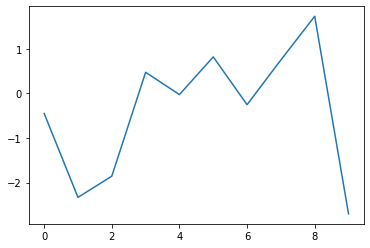

In [6]:
plt.plot(target_data[0])
print(target_summary[0])

In [7]:
prior = tfp.distributions.TruncatedNormal([0., 1.], [10., 10.], [-10., 0.], [10., 10.])

In [8]:
abc_proposals = prior.sample(int(1e6)).numpy()
abc_summaries = compression(simulator(abc_proposals))
abc_distances = np.sqrt(np.sum(np.square(target_summary - abc_summaries), -1))

In [9]:
abc = AutomaticABC(target_data=target_data, prior=prior, simulator=simulator, compression=compression, distance_measure=None)

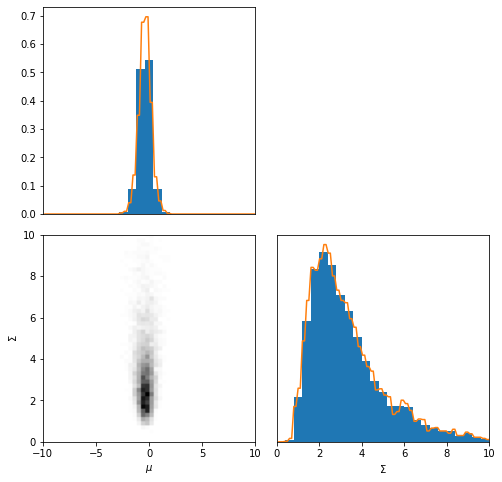

In [16]:
abc.get_simulations(int(1e6))
abc.get_accepted(0.1)
abc.corner_plot(data="accepted", labels=[r"$\mu$", r"$\Sigma$"], kde=False, scatter=False);

In [25]:
ϵ, accepted, rel_entropy, drel_entropy = abc.get_rel_entropy(in_order=True, rate=0.99, ϵ_init=1., skip=1000, return_stats=True, min_samples=1)

Distribution diverging for 10 steps
At turn over ϵ = 0.5353102506902584


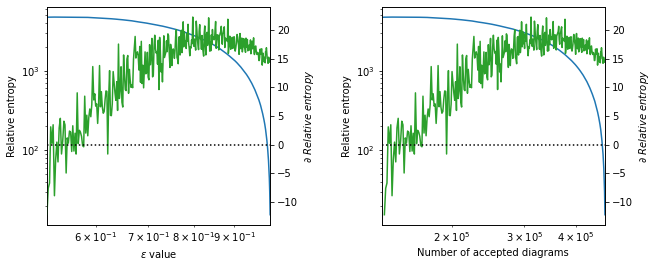

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)
ax0twin = ax[0].twinx()
ax0twin.plot(ϵ, drel_entropy, color="C2")
ax0twin.plot([ϵ.min(), ϵ.max()], [0, 0], color="black", linestyle="dotted")
ax0twin.set_ylabel(r"$\partial~Relative~entropy$")
ax[0].plot(ϵ, rel_entropy[:-2], color="C0")
ax[0].set_xlabel(r"$\epsilon$ value")
ax[0].set_ylabel("Relative entropy")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(ϵ.min(),ϵ.max())
ax1twin = ax[1].twinx()
ax1twin.plot(accepted[:-2], drel_entropy, color="C2")
ax1twin.plot([accepted.min(), accepted.max()], [0, 0], color="black", linestyle="dotted")
ax1twin.set_ylabel(r"$\partial~Relative~entropy$")
ax[1].plot(accepted, rel_entropy, color="C0")
ax[1].set_xlabel("Number of accepted diagrams")
ax[1].set_ylabel("Relative entropy")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim(accepted.min(), accepted.max());

In [27]:
abc.get_accepted(ϵ[-1])

In [28]:
print("Number accepted = {}".format(abc.accepted.shape[0]))
print("Number rejected = {}".format(abc.abc_proposals.shape[0] - abc.accepted.shape[0]))
print("Keep rate = {}".format(abc.accepted.shape[0] / abc.abc_proposals.shape[0]))

Number accepted = 138316
Number rejected = 6861684
Keep rate = 0.01975942857142857


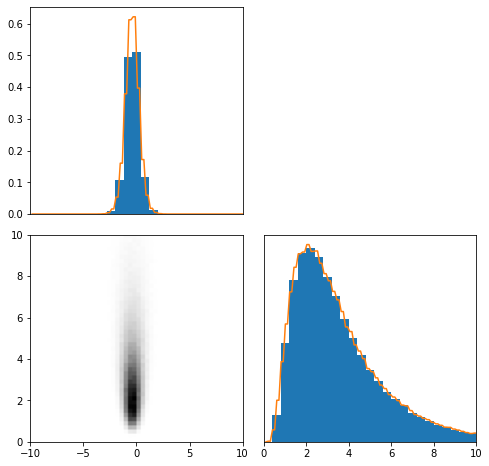

In [29]:
abc.corner_plot();